# Image model explanation using Integrated Gradients

### Imports and installs

In [ ]:
import json
import os
import random
import requests
import shutil

import matplotlib.pyplot as plt
import numpy             as np
import tensorflow        as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
!rm -rf explainable_ai
!git clone https://github.com/kartikparnami/explainable_ai.git
from explainable_ai.integrated_gradients.ig_image import IntegratedGradientsImage

Cloning into 'explainable_ai'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 0), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


### Construct model and utilities

In [ ]:
def preprocessor_with_brightness(img, brightness=None):
  img = tf.image.resize(img, IMG_SIZE)
  img = tf.image.adjust_brightness(img, delta=brightness)
  img = tf.expand_dims(img, axis=0)
  return img

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')


train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


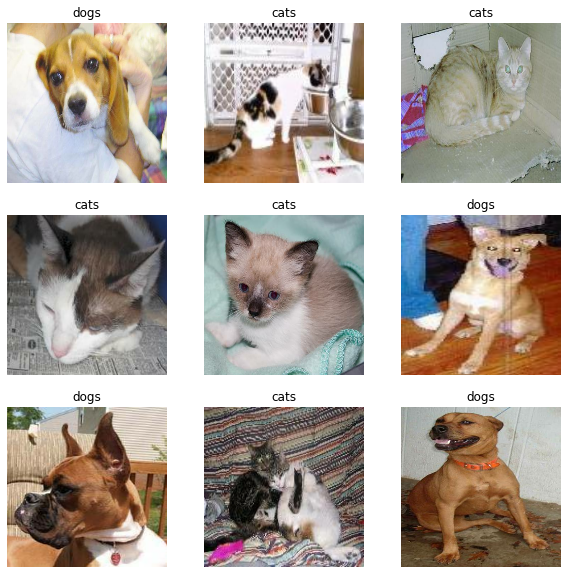

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

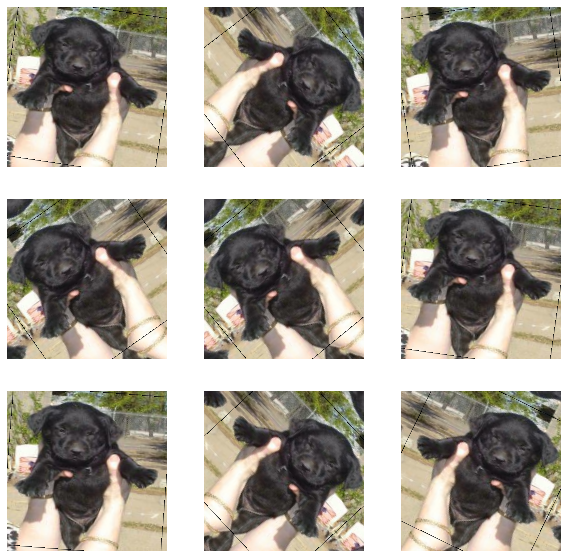

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
def mask_to_categorical(data, mask):
    mask = tf.one_hot(tf.cast(mask, tf.int32), 2)
    mask = tf.cast(mask, tf.float32)
    return data, mask

initial_epochs = 5
history = model.fit(train_dataset.map(mask_to_categorical),
                    epochs=initial_epochs,
                    validation_data=validation_dataset.map(mask_to_categorical))

Epoch 1/5
63/63 [==============================] - 5s 82ms/step - loss: 0.5358 - accuracy: 0.7430 - val_loss: 0.3599 - val_accuracy: 0.8478
Epoch 2/5
63/63 [==============================] - 4s 69ms/step - loss: 0.3918 - accuracy: 0.8230 - val_loss: 0.2365 - val_accuracy: 0.9270
Epoch 3/5
63/63 [==============================] - 4s 70ms/step - loss: 0.3019 - accuracy: 0.8755 - val_loss: 0.1838 - val_accuracy: 0.9468
Epoch 4/5
63/63 [==============================] - 4s 70ms/step - loss: 0.2585 - accuracy: 0.8985 - val_loss: 0.1521 - val_accuracy: 0.9592
Epoch 5/5
63/63 [==============================] - 4s 68ms/step - loss: 0.2259 - accuracy: 0.9085 - val_loss: 0.1328 - val_accuracy: 0.9616


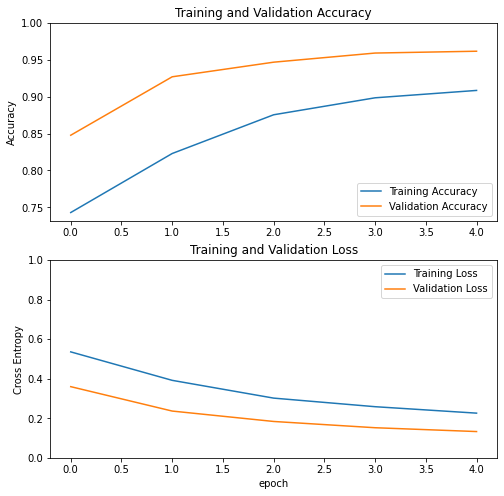

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Integrated Gradients image explanation and visualization

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

img = None
imgs = validation_dataset.take(1).map(mask_to_categorical)
for im in imgs:
    img = im
    break

Found 1000 files belonging to 2 classes.


#### Real cat examples

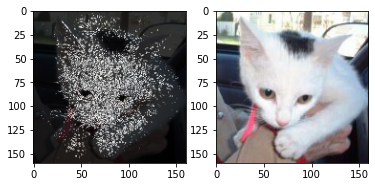

In [ ]:
######################
# Correct Prediction #
######################

image = img[0][4].numpy()
ig_explainer = IntegratedGradientsImage()
overlay_image = ig_explainer.explain_instance(image, preprocessor_with_brightness, model, 100)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(overlay_image.astype('uint8'), cmap=plt.cm.gray)
axes[0].imshow(image.astype('uint8'), alpha=0.2)
axes[1].imshow(image.astype('uint8'))

The most important features that contribute to the cat prediction as identified by the Integrated Gradients technique

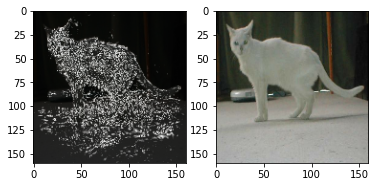

In [ ]:
########################
# Incorrect Prediction #
########################

image = img[0][29].numpy()
ig_explainer = IntegratedGradientsImage()
overlay_image = ig_explainer.explain_instance(image, preprocessor_with_brightness, model, 100)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(overlay_image.astype('uint8'), cmap=plt.cm.gray)
axes[0].imshow(image.astype('uint8'), alpha=0.2)
axes[1].imshow(image.astype('uint8'))

The most important features that contribute to the incorrect prediction of a cat as a dog as identified by the Integrated Gradients technique

#### Real dog examples

In [ ]:
img = None
new_ds = validation_dataset.skip(25)
imgs = new_ds.take(1).map(mask_to_categorical)
for im in imgs:
    img = im
    break

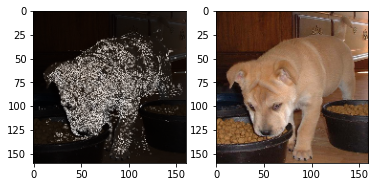

In [ ]:
######################
# Correct Prediction #
######################

image = img[0][18].numpy()
ig_explainer = IntegratedGradientsImage()
overlay_image = ig_explainer.explain_instance(image, preprocessor_with_brightness, model, 100)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(overlay_image.astype('uint8'), cmap=plt.cm.gray)
axes[0].imshow(image.astype('uint8'), alpha=0.2)
axes[1].imshow(image.astype('uint8'))

The most important features that contribute to the dog prediction as identified by the Integrated Gradients technique

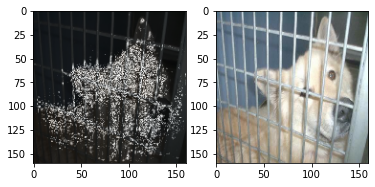

In [ ]:
########################
# Incorrect Prediction #
########################

image = img[0][15].numpy()
ig_explainer = IntegratedGradientsImage()
overlay_image = ig_explainer.explain_instance(image, preprocessor_with_brightness, model, 100)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(overlay_image.astype('uint8'), cmap=plt.cm.gray)
axes[0].imshow(image.astype('uint8'), alpha=0.2)
axes[1].imshow(image.astype('uint8'))

The most important features that contribute to the incorrect prediction of a dog as a cat as identified by the Integrated Gradients technique